Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 10
IMG_SIZE = (180, 180)


Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=IMG_SIZE,
                                                            validation_split= 0.2,
                                                            subset= 'training')

Found 6919 files belonging to 9 classes.
Using 5536 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                            seed=123,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=IMG_SIZE,
                                                            validation_split= 0.2,
                                                            subset= 'validation')

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### code to visualize one instance of all the nine classes present in the dataset

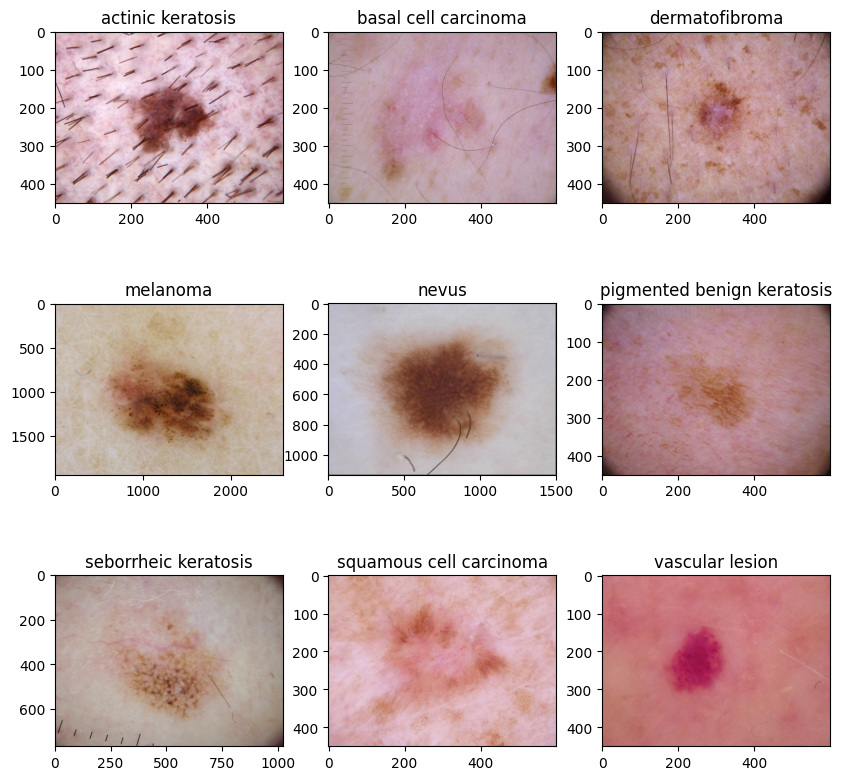

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32), activation ='relu'))
model.add(Conv2D(32, (3, 3), activation ='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation ='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      63,439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,472,617 (242.13 MB)

 Trainable params: 63,472,617 (242.13 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


173/173 ━━━━━━━━━━━━━━━━━━━━ 768s 101ms/step - accuracy: 0.1304 - loss: 3.8223 - val_accuracy: 0.2609 - val_loss: 2.1311
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.2646 - loss: 1.9572 - val_accuracy: 0.1739 - val_loss: 2.1168
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4079 - loss: 1.5861 - val_accuracy: 0.1739 - val_loss: 2.1851
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.4697 - loss: 1.4611 - val_accuracy: 0.1739 - val_loss: 2.5891
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5277 - loss: 1.2946 - val_accuracy: 0.2174 - val_loss: 2.2201
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5826 - loss: 1.1384 - val_accuracy: 0.1739 - val_loss: 2.6263
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6303 - loss: 0.9993 - val_accuracy: 0.3478 - val_loss: 2.7580
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6688 - loss: 0.8895 - val_accur

### Visualizing training results

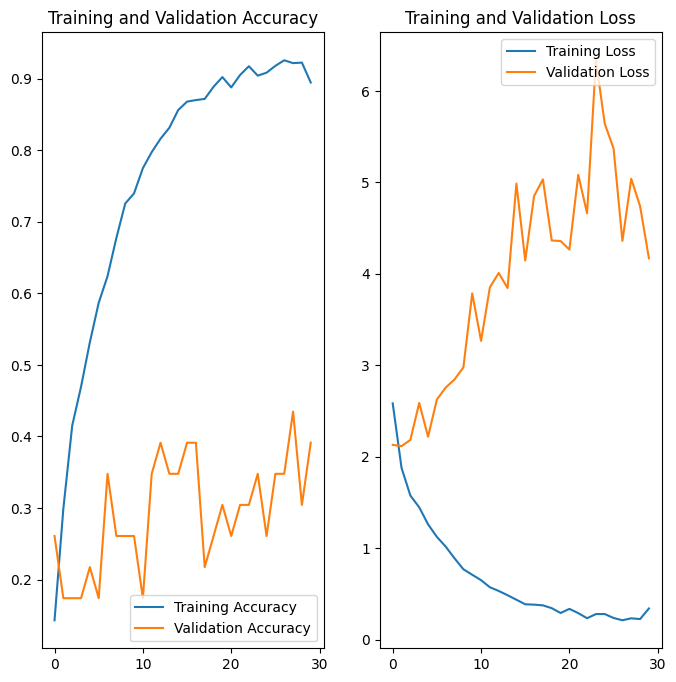

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

# Findings

### The Training accuracy is very high 80-90% but whereas the test accuracy is very low.
### This clearly shows an overfitting problem in the model

## Recommended steps to resolve the overfitting model,
*   Increasing Dropouts




In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2614 - loss: 1.9342 - val_accuracy: 0.2174 - val_loss: 2.3333
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4571 - loss: 1.4397 - val_accuracy: 0.3043 - val_loss: 2.3332
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5639 - loss: 1.1659 - val_accuracy: 0.2174 - val_loss: 2.6409
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6536 - loss: 0.9555 - val_accuracy: 0.2609 - val_loss: 3.6040
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7131 - loss: 0.7881 - val_accuracy: 0.2174 - val_loss: 4.2994
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7791 - loss: 0.6177 - val_accuracy: 0.3043 - val_loss: 4.5310
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8282 - loss: 0.4868 - val_accuracy: 0.3913 - val_loss: 3.6400
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8566 - loss: 0.4120 - val_accu

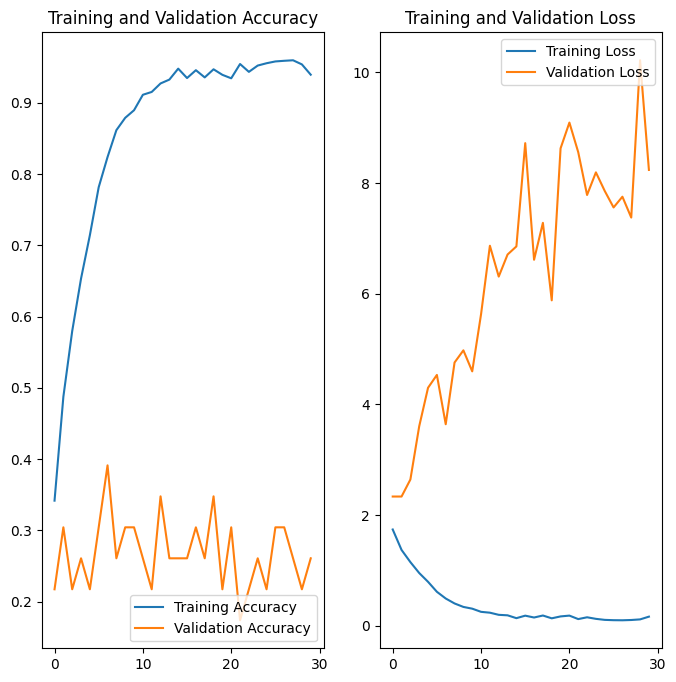

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32), activation ='relu'))
model.add(Conv2D(32, (3, 3), activation ='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(64, (3, 3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation ='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

num_classes = len(class_names)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      63,439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,472,617 (242.13 MB)

 Trainable params: 63,472,617 (242.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.1848 - loss: 3.5780 - val_accuracy: 0.2174 - val_loss: 2.0821
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.3497 - loss: 1.7202 - val_accuracy: 0.2609 - val_loss: 2.1188
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.4460 - loss: 1.5208 - val_accuracy: 0.2609 - val_loss: 2.2408
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5064 - loss: 1.3288 - val_accuracy: 0.2609 - val_loss: 2.0939
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5617 - loss: 1.1649 - val_accuracy: 0.2174 - val_loss: 2.5947
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.6063 - loss: 1.0699 - val_accuracy: 0.2174 - val_loss: 3.1624
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6557 - loss: 0.9511 - val_accuracy: 0.2174 - val_loss: 3.0426
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6820 - loss: 0.8706 - 

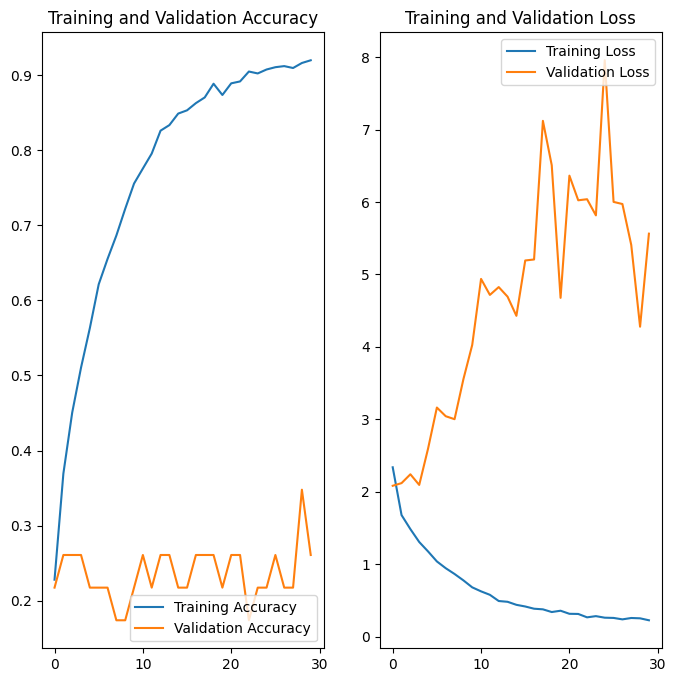

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Findings
## The dropouts has made a very marginal improvement which is not sufficient and it did not reduce the model overfit.



##Visualize distribution of classes in the training dataset.



In [24]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df


,Class,No. of Image
0,nevus,357
1,seborrheic keratosis,77
2,squamous cell carcinoma,181
3,melanoma,438
4,actinic keratosis,114
5,pigmented benign keratosis,462
6,basal cell carcinoma,376
7,dermatofibroma,95
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

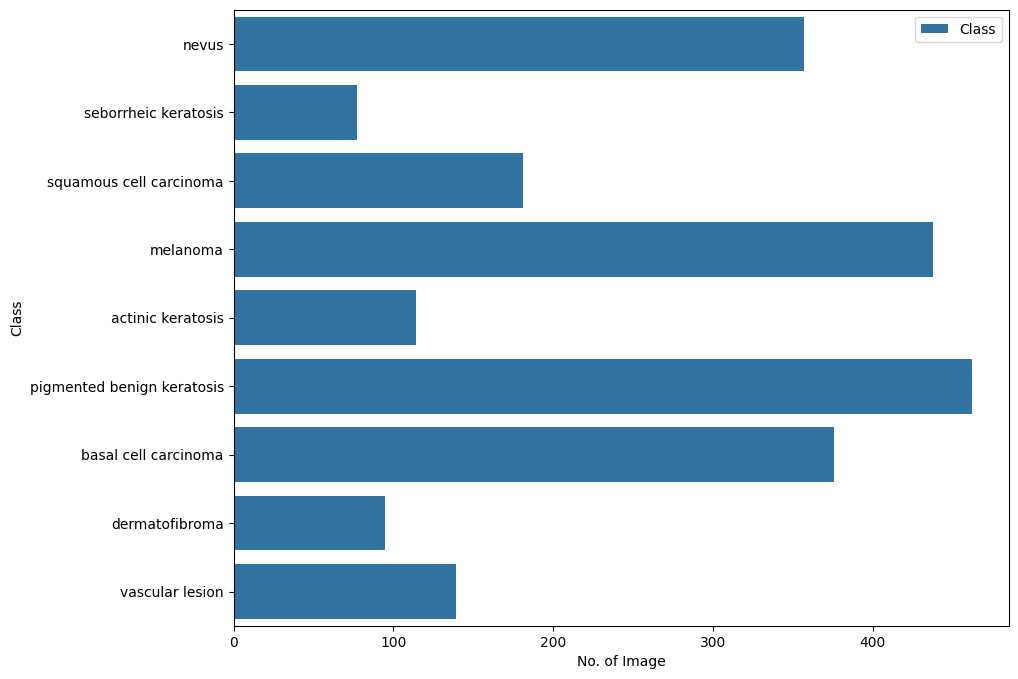

In [25]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

####  Do you think there is some improvement now as compared to the previous model run?

###No, Increasing dropouts didnot improve the overfit problem and reduced the training accuracy by a small margin and improved the validation accuracy by a very small margin. The Overfit is still not resolved


#### - Which class has the least number of samples?
## -- seborrheic keratosis, dermatofibroma, actinic keratosis, vascular lesion
#### - Which classes dominate the data in terms proportionate number of samples?
## -- nevus, melanoma, pigmented benign keratosis, basal cell carcinoma



## Data augmentation
#### Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.


lets implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Lets visualize a few augmented examples by applying data augmentation to the same image several times:

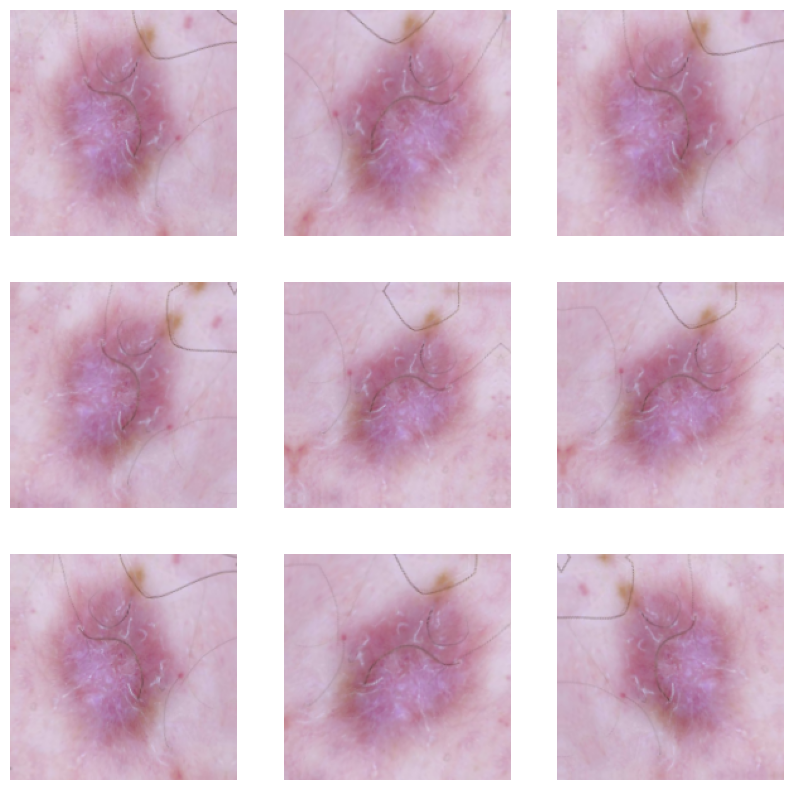

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [28]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.1648 - loss: 2.2463 - val_accuracy: 0.0870 - val_loss: 2.2692
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3547 - loss: 1.6996 - val_accuracy: 0.2609 - val_loss: 2.5270
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4287 - loss: 1.5202 - val_accuracy: 0.3478 - val_loss: 2.8175
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4774 - loss: 1.3919 - val_accuracy: 0.3043 - val_loss: 1.7203
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4979 - loss: 1.3207 - val_accuracy: 0.2174 - val_loss: 2.0364
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5150 - loss: 1.2840 - val_accuracy: 0.2174 - val_loss: 2.6445
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5554 - loss: 1.1782 - val_accuracy: 0.2609 - val_loss: 2.2180
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5519 - loss: 1.1745 - val_acc

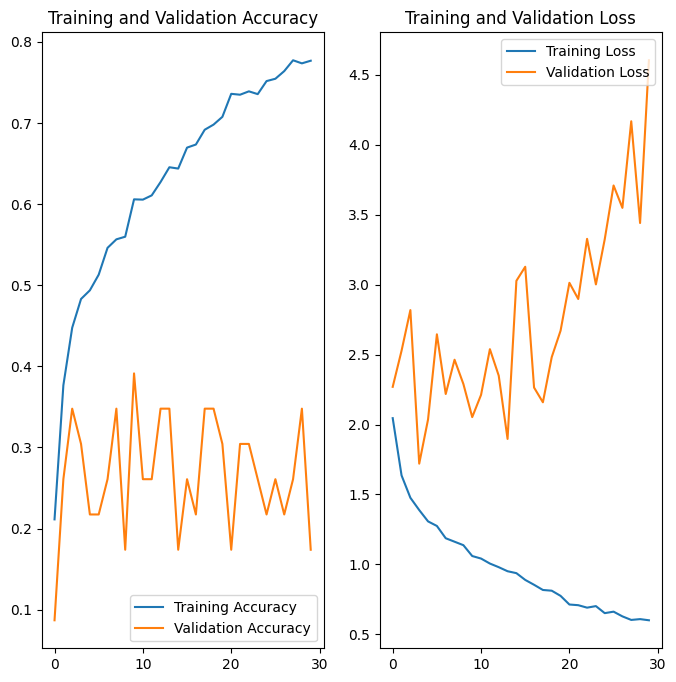

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Findings
## The dropouts, Data Augmentation - following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom is not sufficient and it did not reduce the model overfit.



# Image Classification Augmentation
## Lets use this augmentation technique to generate more samples for image classes which has propotionally less images.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

ugmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4680


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0000033.jpg_a25f9244-37a9-4bd7-bd27-ebee51faa053.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0025427.jpg_e6736b7a-728d-4fc7-8af0-9253335cb831.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0000354.jpg_9c47b906-f74b-4eae-bda0-a6c4e769edba.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0000488.jpg_417b8a9b-6fa9-4baa-b975-70151190d594.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0000335.jpg_78238294-bcb9-4c79-b842-26feae7a3714.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISIC_0024707.jpg_0569526a-86e3-40d5-8619-d07008c2b5c3.jpg',
 '/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train/nevus/output/nevus_original_ISI

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [40]:
new_df['Label'].value_counts()

Label
actinic keratosis             680
nevus                         500
seborrheic keratosis          500
squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
dermatofibroma                500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train="/content/gdrive/MyDrive/Assignment_Repo/CNN_Assignment/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6919 files belonging to 9 classes.
Using 5536 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6919 files belonging to 9 classes.
Using 1383 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32), activation ='relu'))
model.add(Conv2D(32, (3, 3), activation ='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(64, (3, 3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation ='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

num_classes = len(class_names)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      63,439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,472,617 (242.13 MB)

 Trainable params: 63,472,617 (242.13 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


173/173 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.1502 - loss: 3.7272 - val_accuracy: 0.3181 - val_loss: 1.9119
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 43s 250ms/step - accuracy: 0.3576 - loss: 1.7038 - val_accuracy: 0.4570 - val_loss: 1.5351
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.4472 - loss: 1.4611 - val_accuracy: 0.5358 - val_loss: 1.4014
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 84s 253ms/step - accuracy: 0.4901 - loss: 1.3797 - val_accuracy: 0.5748 - val_loss: 1.2632
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 240ms/step - accuracy: 0.5478 - loss: 1.2152 - val_accuracy: 0.6095 - val_loss: 1.1571
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.5839 - loss: 1.1310 - val_accuracy: 0.6457 - val_loss: 1.0521
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.6174 - loss: 1.0368 - val_accuracy: 0.6775 - val_loss: 0.9769
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - accuracy: 0.6713 - loss: 0.9007 - val_a

#### **Todo:**  Visualize the model results

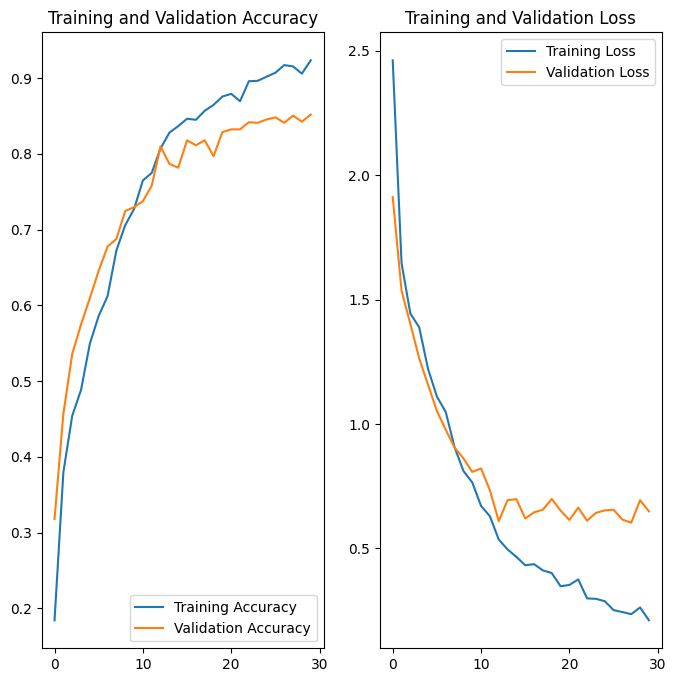

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Yes, The Model Overfit problem seem to be resolved as the model train accuracy is 92% and validation accuracy is 85%.
## The image classification augmentation reduced the overfit problem by a huge margin.

In [48]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [49]:
predictions = probability_model.predict(val_ds)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step


In [52]:
predictions[0]


array([0.25103357, 0.09354354, 0.0934784 , 0.09348013, 0.09431868,
       0.09347951, 0.0934784 , 0.09370934, 0.0934784 ], dtype=float32)

In [53]:
np.argmax(predictions[0])


0

In [55]:
print(predictions)


[[0.25103357 0.09354354 0.0934784  ... 0.0934784  0.09370934 0.0934784 ]
 [0.09805704 0.15803139 0.09724818 ... 0.09717939 0.16066    0.09718405]
 [0.09329855 0.09329855 0.09329855 ... 0.09329855 0.09329855 0.2536117 ]
 ...
 [0.09335279 0.09335302 0.09335279 ... 0.09335313 0.09335279 0.09335279]
 [0.24557315 0.09410208 0.09394578 ... 0.09385592 0.09391055 0.09385022]
 [0.09360713 0.09490284 0.24940722 ... 0.09359065 0.09411069 0.09359607]]


In [58]:
score = tf.nn.softmax(predictions[0])
score

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.1276355 , 0.10903712, 0.10903003, 0.10903022, 0.10912168,
       0.10903015, 0.10903003, 0.10905521, 0.10903003], dtype=float32)>

In [57]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to actinic keratosis with a 12.76 percent confidence.
